<a href="https://colab.research.google.com/github/mddaniya1/asim_jofa_chatbot/blob/main/Agentic_AI_Chatbot_Prototype_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective:

Create a chatbot prototype that talks to users, remembers what they say during conversation, and helps them solve problems.

## Project Requirements:

- ***Choose Your Niche:*** Pick a specific group of people or industry to help with your chatbot (e.g., students, healthcare, customer service).

- ***Make Smart Conversations:*** Make sure the chatbot answers correctly and understands what users want. Use Prompt Engineering.

- ***Add Useful Tools:*** Give the chatbot features like helping users submit complaints, giving outfit ideas, or making study plans.

- ***Short-Term Memory:*** Make the chatbot remember the current conversation to give better answers.

- ***Use Google Colab:*** Build and test your chatbot using this platform.

## Deliverables:

- A working chatbot prototype - Google Collab Link.

- A list of tools and examples of how the chatbot can help people.

# Setup

- First, install the required packages:

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai

- Next, set your API keys:

In [2]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('GEMINI_API_KEY')
tavily_api_key = userdata.get('TAVILY_API_KEY')

- Setting up LLM model

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke("greet me")

AIMessage(content='Hello there!\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f0f3a5f8-1352-49b3-bddb-f6631e60c791-0', usage_metadata={'input_tokens': 3, 'output_tokens': 4, 'total_tokens': 7, 'input_token_details': {'cache_read': 0}})

- Now, creating a chatbot for the students of computer science, which have useful tools and shot-term memory.

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


# Memory for short-term conversation
conversation_memory = {}

def remember_user_input(key, value):
    """Stores user input in conversation memory."""
    conversation_memory[key] = value


# State definition
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Initialize StateGraph
graph_builder = StateGraph(State)


# Tools

def mcb_bank_customer_support(query: str) -> str:
    """Provide responses for common banking customer support queries."""
    prompt = f"Provide a helpful response to the following bank customer support query:\n{query}"
    return llm.invoke(prompt)

def code_explainer(code_snippet: str) -> str:
    """Explain the given code snippet in simple terms."""
    prompt = f"Explain the following code in simple terms:\n\n{code_snippet}"
    return llm.invoke(prompt)

def generate_cheat_sheet(topic: str) -> str:
    """Generate a cheat sheet for a given topic."""
    prompt = f"Create a detailed cheat sheet for the topic: {topic}. Include key points and examples."
    return llm.invoke(prompt)

def smart_todo_list(tasks: str) -> str:
    """Organize the tasks into a smart to-do list."""
    prompt = f"Organize the following tasks into a prioritized to-do list with deadlines:\n{tasks}"
    return llm.invoke(prompt)

def interview_prepration(question: str) -> str:
    """Provide a detailed training for interview question."""
    prompt = f"Provide a list of common interview questions and some tips for preparing for an interview:\n{question}"
    return llm.invoke(prompt)


# Combine all tools
tools = [code_explainer, generate_cheat_sheet, smart_todo_list, interview_prepration]

tools.append(mcb_bank_customer_support)

# Initialize LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)
llm_with_tools = llm.bind_tools(tools)


# System message
sys_msg = SystemMessage(content="You are a helpful assistant for MCB bank customer support. Your role is to provide clear and accurate answers to common customer inquiries related to banking services, such as account details, transactions, loans, and troubleshooting issues.")


# Node
def assistant(state: MessagesState) -> MessagesState:
    # Extract the last user message
    last_message = state["messages"][-1] if state["messages"] else None

    # Check if the last message is a HumanMessage
    if isinstance(last_message, HumanMessage):
        # Remember the user input
        remember_user_input("last_user_input", last_message.content)

    # Prepare the response with memory context
    memory_context = ""
    if "last_user_input" in conversation_memory:
        memory_context = f"Previously, you mentioned: {conversation_memory['last_user_input']}\n"

    # Invoke the LLM with the system message, memory context, and current messages
    response = llm_with_tools.invoke([sys_msg, memory_context] + state["messages"])

    return {"messages": [response]}


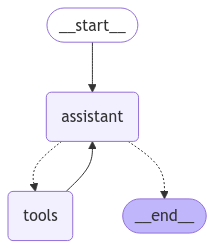

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph: CompiledStateGraph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

- **Explains code snippets in simple terms, making it easier for students to understand complex code.**

In [7]:
messages = [HumanMessage(content="I need help with my MCB bank account balance. Can you check it for me?")]
messages = react_graph.invoke({"messages": messages})

In [8]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I need help with my MCB bank account balance. Can you check it for me?
================================== Ai Message ==================================

I cannot directly access your MCB bank account information due to security and privacy restrictions.  To check your account balance, I recommend using one of the following methods:

* **MCB Bank Mobile App:** Download the official MCB Bank mobile app and log in to view your balance.
* **MCB Bank Online Banking:** Access your account through the MCB Bank online banking portal.
* **Call MCB Bank Customer Service:** Contact MCB Bank's customer service hotline. They can assist you with checking your balance and answer any other questions you may have.
* **Visit a Branch:** Visit your nearest MCB Bank branch.  A bank representative will be able to help.


Please remember to never share your banking credentials (username, password, etc.) with anyone, including 

In [9]:
print(conversation_memory)

{'last_user_input': 'I need help with my MCB bank account balance. Can you check it for me?'}


- **Creates concise cheat sheets for various topics in computer science, summarizing key concepts and examples.**

In [10]:
messages = [HumanMessage(content= "A customer has lost their ATM card. Can you guide them through the process of blocking the card and applying for a replacement?"
)]
messages = react_graph.invoke({"messages": messages})

In [11]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

A customer has lost their ATM card. Can you guide them through the process of blocking the card and applying for a replacement?
================================== Ai Message ==================================

Certainly! Here's how an MCB Bank customer can block their lost ATM card and apply for a replacement:

**1. Immediately Block Your Card:**

* **Call the MCB Bank 24/7 Helpline:**  The fastest way to block your card is to call MCB Bank's customer service hotline.  They will have the necessary information to deactivate your card immediately, preventing any unauthorized transactions.  (You'll need your account details handy).

* **MCB Bank Mobile App (if available):** Many banks offer mobile apps where you can manage your cards. Check if your MCB Bank app has a "Block Card" or similar option.

**2. Report the Loss:**

* **File a Report:** After blocking the card, it's crucial to formally report the los

In [12]:
print(conversation_memory)

{'last_user_input': 'A customer has lost their ATM card. Can you guide them through the process of blocking the card and applying for a replacement?'}


- **Organizes tasks into a prioritized to-do list, helping students manage their assignments and projects effectively.**

In [13]:
messages = [HumanMessage(content="Can you assist the customer in setting up MCB's mobile banking app and explain how to use it for everyday transactions?")]
messages = react_graph.invoke({"messages": messages})

In [14]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Can you assist the customer in setting up MCB's mobile banking app and explain how to use it for everyday transactions?
================================== Ai Message ==================================

Certainly! I can help you guide a customer through setting up MCB's mobile banking app and using it for everyday transactions.  However, I need more information about MCB's specific mobile banking app.  To give accurate instructions, please provide details such as:

* **App Name:** The exact name of the MCB mobile banking app (e.g., "MCB Mobile," "MCB Bank App").
* **App Store Links:** Links to download the app from the Apple App Store and Google Play Store.
* **Registration Process:** A step-by-step description of the registration process, including required information (account number, CNIC, etc.) and security measures.
* **Transaction Features:** A list of the app's features, such as fund transfers, bill

In [15]:
print(conversation_memory)

{'last_user_input': "Can you assist the customer in setting up MCB's mobile banking app and explain how to use it for everyday transactions?"}


In [16]:
messages = [
    HumanMessage(content="I apologize for the previous error. I am still learning to access and process information. Please let me know if you're experiencing issues with MCB Bank services. For example, are you having trouble with online banking, account access, transactions, or something else? Please provide details such as error messages or actions that led to the issue.")
]

messages = llm_with_tools.invoke(messages)

In [17]:
messages.pretty_print()

================================== Ai Message ==================================

I do not have personal experiences or the ability to access and process information like a human user.  I am a language model and cannot interact with MCB Bank services directly.  Therefore, I cannot report any issues I'm experiencing.  To get help with MCB Bank services, you should contact their customer support directly.


In [18]:
print(conversation_memory)

{'last_user_input': "Can you assist the customer in setting up MCB's mobile banking app and explain how to use it for everyday transactions?"}


In [ ]:
def stream_graph_updates(user_input: str):
    for event in react_graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Wa alaikum assalam!  How can I help you today?

Assistant: 
Assistant: content="## Bank Cheat Sheet: Key Concepts & Terminology\n\nThis cheat sheet covers essential aspects of banks and their operations.\n\n**I. Core Functions of Banks:**\n\n* **Accepting Deposits:** Banks collect funds from individuals and businesses, offering various account types:\n    * **Checking Accounts:** For everyday transactions; debit cards often linked.  *Example:* Writing checks, using ATMs.\n    * **Savings Accounts:** For accumulating funds; typically earns interest. *Example:*  Saving for a down payment.\n    * **Money Market Accounts:** Higher interest rates than savings, often with limited transactions. *Example:*  Short-term investment vehicle.\n    * **Certificates of Deposit (CDs):** Fixed-term deposits with a fixed interest rate; penalties for early withdrawal. *Example:*  Guaranteed return for a specific period.\n\n* **Providing Loans:** Banks lend money to individuals and businesses, 